In [1]:
import copy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error
import shap
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import OutlierTrimmer
from catboost import CatBoostRegressor, Pool

SEED = 23

pd.set_option('display.max_columns', None)

In [ ]:
#pip install --force-reinstall --upgrade git+https://github.com/SerjWeesp/AmarinML.git
from amarinml import *

In [3]:
df = pd.read_csv('D:/OneDrive/datasets/sp500_diff.csv', low_memory=False)

In [4]:
df.drop(columns=['Unnamed: 0'], axis=1, inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27723 entries, 0 to 27722
Columns: 401 entries, Ticker to eps-earnings-per-share-diluted_pct_diff_4
dtypes: float64(396), int64(1), object(4)
memory usage: 84.8+ MB


In [6]:
df = df.sort_values(by=['Ticker','Date'])

In [7]:
target = 'Future_Price_pct_diff_1'
df[target]=df.groupby('Ticker')['ClosePrice_pct_diff_1'].shift(1)

In [8]:
df[target].describe()

count    27228.000000
mean         0.044192
std          0.150074
min         -0.835395
25%         -0.039721
50%          0.042890
75%          0.124788
max          2.553191
Name: Future_Price_pct_diff_1, dtype: float64

In [9]:
df.dropna(inplace = True)

In [10]:
df = df.sort_values(by=['Date','Ticker'])

In [11]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED, shuffle=False)

In [12]:
features = df.drop(columns=[target], axis=1).columns
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

train_pool = Pool(train_df[features], label=train_df[target], cat_features=cat_features)
test_pool = Pool(test_df[features], label=test_df[target], cat_features=cat_features)

In [13]:
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [20]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    random_seed=SEED,
    verbose=50,
    thread_count=-1,  # Use all available threads
    task_type="CPU"   # Ensure CPU is used
)

In [21]:
model.fit(train_pool)

0:	learn: 0.1420593	total: 198ms	remaining: 3m 17s
50:	learn: 0.0653811	total: 8.44s	remaining: 2m 37s
100:	learn: 0.0574887	total: 16.7s	remaining: 2m 29s
150:	learn: 0.0516988	total: 25.1s	remaining: 2m 20s
200:	learn: 0.0478070	total: 33.3s	remaining: 2m 12s
250:	learn: 0.0446973	total: 41.6s	remaining: 2m 4s
300:	learn: 0.0419920	total: 50s	remaining: 1m 56s
350:	learn: 0.0396947	total: 58.2s	remaining: 1m 47s
400:	learn: 0.0375875	total: 1m 6s	remaining: 1m 39s
450:	learn: 0.0356831	total: 1m 14s	remaining: 1m 30s
500:	learn: 0.0337719	total: 1m 22s	remaining: 1m 22s
550:	learn: 0.0320997	total: 1m 31s	remaining: 1m 14s
600:	learn: 0.0306008	total: 1m 39s	remaining: 1m 6s
650:	learn: 0.0292103	total: 1m 47s	remaining: 57.7s
700:	learn: 0.0277946	total: 1m 55s	remaining: 49.4s
750:	learn: 0.0264302	total: 2m 4s	remaining: 41.1s
800:	learn: 0.0252269	total: 2m 12s	remaining: 32.9s
850:	learn: 0.0241811	total: 2m 20s	remaining: 24.6s
900:	learn: 0.0230630	total: 2m 28s	remaining: 16.

In [ ]:
# Retrieve feature importances
importances = model.get_feature_importance()

# Retrieve the corresponding feature names (if available)
feature_names = model.feature_names_

# Create a DataFrame with the feature names and their importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame in descending order by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Print the top 30 important features
print(importance_df.head(30))

                           feature  importance
265            MinPrice_pct_diff_1   22.922979
251            MaxPrice_pct_diff_1   13.566471
165          ClosePrice_pct_diff_1   11.824799
1                             Date    9.662177
249           MarketCap_pct_diff_1    3.126672
266            MinPrice_pct_diff_4    2.302344
166          ClosePrice_pct_diff_4    1.980998
70                          RSI_14    1.603870
367            StdPrice_pct_diff_1    1.358624
250           MarketCap_pct_diff_4    1.163195
347              RSI_14_pct_diff_1    1.063409
35                     MACD_Signal    0.984921
259          MeanVolume_pct_diff_1    0.737230
258           MeanPrice_pct_diff_4    0.730424
34                       MACD_Hist    0.713945
257           MeanPrice_pct_diff_1    0.709398
263        MedianVolume_pct_diff_1    0.686994
33                            MACD    0.616051
134                    GICS Sector    0.612909
368            StdPrice_pct_diff_4    0.511330
252          

In [23]:
preds = model.predict(test_pool)
rmse = np.sqrt(mean_squared_error(test_df[target], preds))
print("Test RMSE:", rmse) 

Test RMSE: 0.07590568914154557


In [29]:
errors = np.abs(test_df[target] - preds)

# Create a DataFrame to store actual, predicted, and errors
error_df = test_df[['Ticker', 'Date', target]].copy()
error_df['Predicted'] = preds
error_df['Error'] = errors

# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(by='Error', ascending=False).head(30)
print(top_30_errors)

      Ticker        Date  Future_Price_pct_diff_1  Predicted     Error
22705   SMCI  2024-06-30                 2.553191   0.391897  2.161294
22702   SMCI  2023-09-30                 1.339277   0.735000  0.604277
4598     CCL  2023-11-30                 0.408727  -0.027731  0.436458
24853   TSLA  2023-06-30                 0.684202   0.300760  0.383442
10674   FSLR  2024-09-30                 0.335664  -0.036042  0.371705
4599     CCL  2024-02-29                -0.048040   0.298083  0.346123
17617   MRNA  2024-09-30                 0.114396  -0.174816  0.289212
18370    NEM  2024-06-30                -0.127259   0.138465  0.265724
26681    WDC  2023-06-30                 0.193978  -0.053096  0.247074
19795   PARA  2023-06-30                 0.337759   0.090711  0.247048
16771   META  2023-06-30                 0.761177   0.517342  0.243835
17970   MTCH  2024-03-31                -0.068283   0.171754  0.240037
20614   PLTR  2023-06-30                 0.316199   0.076784  0.239416
1237  

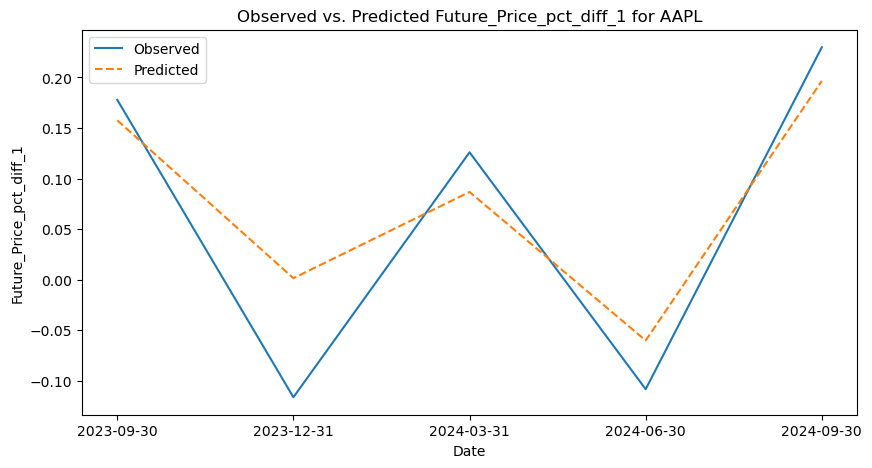

In [ ]:
ticker_example = test_df[test_df['Ticker'] == 'AAPL']
plt.figure(figsize=(10, 5))
plt.plot(ticker_example['Date'], ticker_example[target], label='Observed')
plt.plot(ticker_example['Date'], model.predict(Pool(ticker_example[features], cat_features=cat_features)),
         label='Predicted', linestyle='--')
plt.title(f'Observed vs. Predicted {target} for {ticker_example["Ticker"].iloc[0]}')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit  # or KFold, as needed
from sklearn.metrics import mean_squared_error, make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Integer
#from skopt.callbacks import TqdmCallback
import warnings
warnings.filterwarnings('ignore')

# --- Step 1: Create a Custom Wrapper for CatBoost ---

class CatBoostRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, cat_features=None, **kwargs):
        """
        Wrapper for CatBoostRegressor that supports hyperparameter tuning via scikit-learn.
        
        Parameters:
            cat_features: list of column names or indices to be treated as categorical.
            **kwargs: additional hyperparameters for CatBoostRegressor.
        """
        self.cat_features = cat_features
        self.kwargs = kwargs  # store additional CatBoost parameters
        self.model_ = None

    def fit(self, X, y, **fit_params):
        # Convert data to a CatBoost Pool using provided categorical features.
        pool = Pool(data=X, label=y, cat_features=self.cat_features)
        # Create and fit the CatBoostRegressor with the stored parameters.
        self.model_ = CatBoostRegressor(**self.get_params())
        self.model_.fit(pool, **fit_params)
        return self

    def predict(self, X):
        pool = Pool(data=X, cat_features=self.cat_features)
        return self.model_.predict(pool)

    def score(self, X, y):
        preds = self.predict(X)
        return -mean_squared_error(y, preds)

    def get_params(self, deep=True):
        # Return a dict of parameters that includes 'cat_features' and all kwargs.
        params = {'cat_features': self.cat_features}
        params.update(self.kwargs)
        return params

    def set_params(self, **parameters):
        # Update parameters and return self.
        for key, value in parameters.items():
            if key == 'cat_features':
                self.cat_features = value
            else:
                self.kwargs[key] = value
        return self

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# --- Step 3: Setup Advanced Hyperparameter Tuning with BayesSearchCV ---

# Define the search space using skopt.space objects
search_spaces = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'depth': Integer(3, 10),
    'l2_leaf_reg': Real(1e-9, 10, prior='log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'border_count': Integer(32, 255),
    'iterations': Integer(100, 1000),
    'subsample': Real(0.5, 1.0)
}

# Define initial fixed parameters if desired (you can leave them to be tuned as well)
fixed_params = {
    'random_seed': 23,
    'verbose': 0,
    'thread_count': 8
}

# Merge fixed parameters into initial parameters of our estimator
init_params = {**fixed_params}

# Initialize the custom wrapper estimator, passing the list of categorical feature names.
estimator = CatBoostRegressorWrapper(cat_features=cat_features, **init_params)

# Define cross-validation. For time series you might use TimeSeriesSplit; here we use KFold for simplicity.
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=False)

# Number of iterations for Bayesian search and initialize a progress callback
n_iter = 3
callback = TqdmCallback(total=n_iter)

# Setup BayesSearchCV
optimizer = BayesSearchCV(
    estimator=estimator,
    search_spaces=search_spaces,
    n_iter=n_iter,
    cv=cv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1,
    n_points=8,
    return_train_score=True,
    verbose=0,
    random_state=23
)

# --- Step 4: Run the Hyperparameter Tuning ---
optimizer.fit(X_train, y_train, callback=callback)
callback.pbar.close()

print("Best Parameters:", optimizer.best_params_)
print("Best CV Score (Negative MSE):", optimizer.best_score_)

# --- Step 5: Evaluate on Test Data ---
best_estimator = optimizer.best_estimator_
preds_test = best_estimator.predict(X_test)
test_mse = mean_squared_error(y_test, preds_test)
print("Test MSE:", test_mse)



  0%|                                                                                          | 0/100 [41:34<?, ?it/s]


KeyboardInterrupt: 